# (강의) 비디오분류

신록예찬  
2024-10-01

# 1. 강의영상

# 2. Ref

ref:
<https://huggingface.co/docs/transformers/tasks/video_classification>

In [1]:
from huggingface_hub import hf_hub_download

hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset")

/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

In [2]:
import tarfile

with tarfile.open(file_path) as t:
     t.extractall(".")

In [3]:
import pathlib
dataset_root_path = "UCF101_subset"
dataset_root_path = pathlib.Path(dataset_root_path)

In [4]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 405

In [5]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
 )
all_video_file_paths[:5]

[PosixPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g09_c06.avi'),
 PosixPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g06_c03.avi'),
 PosixPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c01.avi'),
 PosixPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g04_c07.avi'),
 PosixPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g19_c02.avi')]

In [6]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")


Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].

In [7]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [8]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [9]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

In [10]:
import os
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

In [11]:
train_dataset

In [12]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [13]:
print(train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos)

300 30 75

In [14]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

<IPython.core.display.Image object>

In [16]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 4
batch_size = 16
args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [17]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [18]:
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs

In [20]:
import torch
train_results = trainer.train()

In [37]:
sample_test_video = next(iter(test_dataset))
display_gif(sample_test_video['video'])

<IPython.core.display.Image object>

In [44]:
from transformers import pipeline
video_cls = pipeline("video-classification",model="videomae-base-finetuned-ucf101-subset/checkpoint-72/")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.

In [45]:
video_cls("https://huggingface.co/datasets/sayakpaul/ucf101-subset/resolve/main/v_BasketballDunk_g14_c06.avi")

[{'score': 0.7359927892684937, 'label': 'BasketballDunk'},
 {'score': 0.08402405679225922, 'label': 'BandMarching'},
 {'score': 0.050819315016269684, 'label': 'BalanceBeam'},
 {'score': 0.050216369330883026, 'label': 'BaseballPitch'},
 {'score': 0.02926969900727272, 'label': 'BabyCrawling'}]

# 4. 살펴보기

# pip install pytorchvideo \# conda install conda-forge::pytorchvideo

# pip install imageio

In [28]:
import huggingface_hub
import tarfile 
import pathlib
import transformers
import pytorchvideo.data
import pytorchvideo.transforms
import torchvision.transforms
import os 
import evaluate
import torch
import numpy as np
import imageio
import IPython.display
import matplotlib.pyplot as plt 

/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

In [10]:
def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return IPython.display.Image(filename=gif_filename)

# sample_video = next(iter(train_dataset))
# video_tensor = sample_video["video"]
# display_gif(video_tensor)

## A. 다운로드

`-` 처음 `/home/cgb3/.cache/`의 상태

`-` `huggingface_hub.hf_hub_download` 의 역할: (1)
“UCF101_subset.tar.gz” 라는 압축파일을 다운로드 (2) 다운로드한
압축파일의 경로를 `str`으로 리턴

In [11]:
file_path = huggingface_hub.hf_hub_download(
    repo_id="sayakpaul/ucf101-subset", 
    filename="UCF101_subset.tar.gz", 
    repo_type="dataset"
)

In [12]:
file_path

'/home/cgb3/.cache/huggingface/hub/datasets--sayakpaul--ucf101-subset/snapshots/b9984b8d2a95e4a1879e1b071e9433858d0bc24a/UCF101_subset.tar.gz'

## B. 압축풀기

`-` `tarfile.open` 사용방법1

In [5]:
t = tarfile.open(file_path)

`-` `t` 의 주요기능

In [6]:
t.closed

False

In [7]:
t._check()

In [8]:
t.extractall("여기에")

In [9]:
t.extractall("asdf")

In [10]:
t.extractall(".")

In [11]:
t.close()

In [12]:
t.closed

True

In [13]:
t.extractall("저기에")

In [14]:
t._check()

`-` `tarfile.open` + `with` 문

*아래의 코드를 작성하고 싶음*

``` python
1. `TarFile` 오브젝트 만듦.
2. 열린상태인지 체크. (열린상태라면 에러메시지 발생하고 진행중지)
3. 압축해제.
4. 닫음.
```

*아래와 같이 쓸 수 있음*

In [20]:
t = tarfile.open(file_path)
t._check()
t.extractall(".")
t.close()


*이것을 아래와 같이 줄일 수 있음*

In [21]:
with tarfile.open(file_path) as t:
    t.extractall(".")

## C. 영상확인

`-` 원래는 아래가 실행되어야함.

In [22]:
IPython.display.Video('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c03.avi')

Your browser does not support the video element.

`-` `avi`를 `mp4`로 변환

In [232]:
#!conda install conda-forge::ffmpeg
!ffmpeg -i UCF101_subset/train/Basketball/v_Basketball_g01_c01.avi -vcodec libx264 -acodec aac output_video.mp4 -y

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-7)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716145014501/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716145014501/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716145014501/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716145014501/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716145014501/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libo

`-` 영상확인

In [30]:
IPython.display.Video('output_video.mp4')

Your browser does not support the video element.

## D. 영상 불러오기

### `#` 영상 $\to$ 텐서 // 불러오기

`-` 데이터 불러오기

In [56]:
_train = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("random", 15),
    decode_audio = False,
)

In [57]:
set(dir(_train)) & {'__next__'}

{'__next__'}

In [58]:
video_tensor = next(_train)['video']
video_tensor.shape

torch.Size([3, 141, 240, 320])

### `#` 텐서 $\to$ 영상 // 확인용

`-` 차원변환

In [59]:
video_tensor.permute(1,2,3,0).shape

torch.Size([141, 240, 320, 3])

`-` 자료형변환전

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].

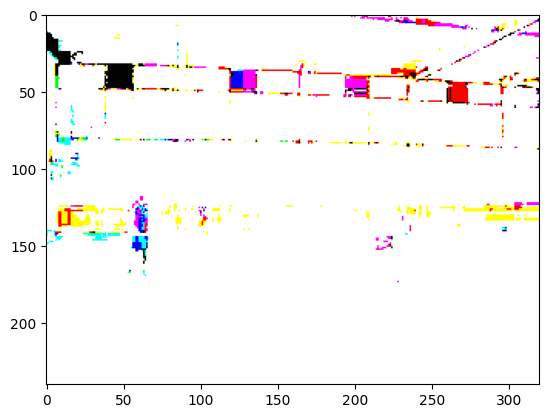

In [60]:
plt.imshow(video_tensor.permute(1,2,3,0)[0])

`-` 자료형 변환 후

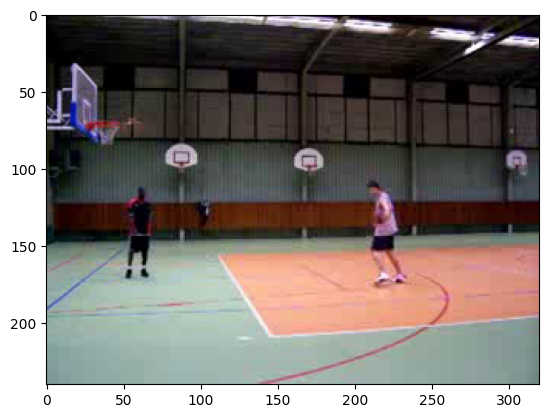

In [61]:
img = video_tensor.permute(1,2,3,0)[0].numpy()
plt.imshow(img.astype("uint8"))

`-` gif 만들기

In [65]:
frames = [] 
for video_frame in video_tensor.permute(1,2,3,0):
    frames.append(video_frame.numpy().astype("uint8"))

In [73]:
imageio.mimsave("sample.gif",frames,duration=0.25)

`-` gif이미지 display 하기

In [69]:
IPython.display.Image(filename="sample.gif")

<IPython.core.display.Image object>

`-` 정리하기

In [95]:
def _display_gif(video_tensor):
    #---#
    frames = [] 
    for video_frame in video_tensor.permute(1,2,3,0):
        img = video_frame.numpy().astype("uint8")
        frames.append(img)
    imageio.mimsave("sample.gif",frames)
    return IPython.display.Image(filename="sample.gif")    

In [96]:
_display_gif(video_tensor)

<IPython.core.display.Image object>

## E. 모델생성

In [97]:
id2label = {
    0: 'ApplyEyeMakeup',
    1: 'Archery',
    2: 'BalanceBeam',
    3: 'BaseballPitch',
    4: 'BasketballDunk',
    5: 'ApplyLipstick',
    6: 'BabyCrawling',
    7: 'BandMarching',
    8: 'Basketball',
    9: 'BenchPress'
}

In [98]:
label2id = {
    'ApplyEyeMakeup': 0, 
    'Archery': 1,
    'BalanceBeam': 2,
    'BaseballPitch': 3,
    'BasketballDunk': 4,
    'ApplyLipstick': 5,
    'BabyCrawling': 6,
    'BandMarching': 7,
    'Basketball': 8,
    'BenchPress': 9 
}

In [99]:
model = transformers.VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [100]:
model.config.num_frames

16

## F. 변환 $\to$ tr/val/test 생성

`-` 모델에 최적화된 변환기

In [101]:
image_processor = transformers.VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base")

`-` 저장된 값들

In [102]:
print(
    f"mean : {image_processor.image_mean}\n"
    f"std: {image_processor.image_std}\n" 
    f"size: {image_processor.size}\n"
    f"resize_to: {(224,224)}\n"
    f"num_frames_to_sample: {16}\n"
    f"clip_duration: {16 * 4 / 30}"
)

mean : [0.485, 0.456, 0.406]
std: [0.229, 0.224, 0.225]
size: {'shortest_edge': 224}
resize_to: (224, 224)
num_frames_to_sample: 16
clip_duration: 2.1333333333333333

`-` 최적화된 변환을 적용하여 다시 텐서를 부름

In [123]:
train_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("random", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
        key = "video",
        transform = torchvision.transforms.Compose(
            [
                pytorchvideo.transforms.UniformTemporalSubsample(16),
                torchvision.transforms.Lambda(lambda x: x / 255.0),
                pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                pytorchvideo.transforms.RandomShortSideScale(min_size=256, max_size=320),
                torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.RandomHorizontalFlip(p=0.5)
            ]
        )
    )
)

`-` 변화된 텐서에 맞는 `display_gif`를 새로 선언

In [124]:
def display_gif(video_tensor):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    #---#
    frames = [] 
    for video_frame in video_tensor.permute(1,2,3,0):
        img = video_frame.numpy()
        img = (img * std) + mean 
        img = (img * 255).astype("uint8")
        img = img.clip(0, 255)
        frames.append(img)
    imageio.mimsave("sample.gif",frames)
    return IPython.display.Image(filename="sample.gif")    

In [125]:
display_gif(next(train)['video'])

<IPython.core.display.Image object>

`-` 각 변환의 의미를 살펴보자.

-   `UniformTemporalSubsample(16)`:
-   `Lambda(lambda x: x / 255.0)`:
-   `Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`:
-   `RandomShortSideScale(min_size=256, max_size=320)`:
-   `RandomHorizontalFlip(p=0.5)`:

In [130]:
train_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("random", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
        key = "video",
        transform = torchvision.transforms.Compose(
            [
                pytorchvideo.transforms.UniformTemporalSubsample(16),
                torchvision.transforms.Lambda(lambda x: x / 255.0),
                pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                pytorchvideo.transforms.RandomShortSideScale(min_size=256, max_size=320),
                torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.RandomHorizontalFlip(p=0.5)
            ]
        )
    )
)
display_gif(next(train)['video'])

<IPython.core.display.Image object>

`-` test, val 도 불러오자.

In [131]:
test_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
        key = "video",
        transform = torchvision.transforms.Compose(
            [
                pytorchvideo.transforms.UniformTemporalSubsample(16),
                torchvision.transforms.Lambda(lambda x: x / 255.0),
                pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                #pytorchvideo.transforms.RandomShortSideScale(min_size=256, max_size=320),
                torchvision.transforms.Resize((224, 224)),
                #torchvision.transforms.RandomHorizontalFlip(p=0.5)
            ]
        )
    )
)
val_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
        key = "video",
        transform = torchvision.transforms.Compose(
            [
                pytorchvideo.transforms.UniformTemporalSubsample(16),
                torchvision.transforms.Lambda(lambda x: x / 255.0),
                pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                #pytorchvideo.transforms.RandomShortSideScale(min_size=256, max_size=320),
                torchvision.transforms.Resize((224, 224)),
                #torchvision.transforms.RandomHorizontalFlip(p=0.5)
            ]
        )
    )
)

## G. 데이터콜렉터

`-` 일단 아래가 실행되지 않음을 관찰하자.

In [134]:
model(train_dataset)

`-` 실행되는 형태1: `model(tsr-nfchw)`

In [168]:
examples = [next(train_dataset), next(train_dataset)] 

In [171]:
examples[0]['video'].shape, examples[1]['video'].shape

(torch.Size([3, 16, 224, 224]), torch.Size([3, 16, 224, 224]))

In [172]:
examples[0]['video'].permute(1,0,2,3).shape, examples[1]['video'].permute(1,0,2,3).shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 3, 224, 224]))

In [174]:
torch.stack([examples[0]['video'].permute(1,0,2,3), examples[1]['video'].permute(1,0,2,3)]).shape

torch.Size([2, 16, 3, 224, 224])

In [180]:
tsr = torch.stack([examples[i]['video'].permute(1,0,2,3) for i in range(2)])
tsr.shape

torch.Size([2, 16, 3, 224, 224])

In [181]:
model(tsr)

ImageClassifierOutput(loss=None, logits=tensor([[ 0.4671,  0.4103, -0.3659,  0.0303,  0.1490, -0.5198, -0.4376, -0.2202,
          0.3834,  0.2408],
        [ 0.7669, -0.0123, -0.1794,  0.3096,  0.4815, -0.1627, -0.0231, -0.3684,
          0.1878, -0.1508]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

`-` 실행되는 형태2:
`model(**{"pixel_values": tsr-nfchw, "labels": tsr-n})`

In [184]:
examples[0]['label'], examples[1]['label']

(9, 2)

In [186]:
[examples[i]['label'] for i in range(2)]

[9, 2]

In [189]:
labels = torch.tensor([examples[i]['label'] for i in range(2)])
labels

tensor([9, 2])

In [190]:
model(**{'pixel_values':tsr, "labels": labels})

ImageClassifierOutput(loss=tensor(2.3808, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.4671,  0.4103, -0.3659,  0.0303,  0.1490, -0.5198, -0.4376, -0.2202,
          0.3834,  0.2408],
        [ 0.7669, -0.0123, -0.1794,  0.3096,  0.4815, -0.1627, -0.0231, -0.3684,
          0.1878, -0.1508]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

`-` 그렇다면 데이터콜렉터는?

In [191]:
def collate_fn(examples):
    tsr = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([examples[i]['label'] for i in range(2)])
    return dict(pixel_values=tsr, labels=labels)

In [192]:
model(**collate_fn(examples))

ImageClassifierOutput(loss=tensor(2.3808, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.4671,  0.4103, -0.3659,  0.0303,  0.1490, -0.5198, -0.4376, -0.2202,
          0.3834,  0.2408],
        [ 0.7669, -0.0123, -0.1794,  0.3096,  0.4815, -0.1627, -0.0231, -0.3684,
          0.1878, -0.1508]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

`-` 좀 더 일반화

In [197]:
def collate_fn(examples):
    tsr = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example['label'] for example in examples])
    return dict(pixel_values=tsr, labels=labels)
model(**collate_fn(examples))    

# 5. 코드정리

In [ ]:
import huggingface_hub
import tarfile 
import pathlib
import transformers
import pytorchvideo.data
import pytorchvideo.transforms
import torchvision.transforms
# import os 
import evaluate
import torch
import numpy as np
# import imageio
# import IPython.display
# import matplotlib.pyplot as plt 
#---#
## Step1 
file_path = huggingface_hub.hf_hub_download(
    repo_id="sayakpaul/ucf101-subset", 
    filename="UCF101_subset.tar.gz", 
    repo_type="dataset"
)
with tarfile.open(file_path) as t:
    t.extractall(".")
train_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("random", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
        key = "video",
        transform = torchvision.transforms.Compose(
            [
                pytorchvideo.transforms.UniformTemporalSubsample(16),
                torchvision.transforms.Lambda(lambda x: x / 255.0),
                pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                pytorchvideo.transforms.RandomShortSideScale(min_size=256, max_size=320),
                torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.RandomHorizontalFlip(p=0.5)
            ]
        )
    )
)
test_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
        key = "video",
        transform = torchvision.transforms.Compose(
            [
                pytorchvideo.transforms.UniformTemporalSubsample(16),
                torchvision.transforms.Lambda(lambda x: x / 255.0),
                pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                #pytorchvideo.transforms.RandomShortSideScale(min_size=256, max_size=320),
                torchvision.transforms.Resize((224, 224)),
                #torchvision.transforms.RandomHorizontalFlip(p=0.5)
            ]
        )
    )
)
val_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
        key = "video",
        transform = torchvision.transforms.Compose(
            [
                pytorchvideo.transforms.UniformTemporalSubsample(16),
                torchvision.transforms.Lambda(lambda x: x / 255.0),
                pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                #pytorchvideo.transforms.RandomShortSideScale(min_size=256, max_size=320),
                torchvision.transforms.Resize((224, 224)),
                #torchvision.transforms.RandomHorizontalFlip(p=0.5)
            ]
        )
    )
)
## Step2 
id2label = {
    0: 'ApplyEyeMakeup',
    1: 'Archery',
    2: 'BalanceBeam',
    3: 'BaseballPitch',
    4: 'BasketballDunk',
    5: 'ApplyLipstick',
    6: 'BabyCrawling',
    7: 'BandMarching',
    8: 'Basketball',
    9: 'BenchPress'
}
label2id = {
    'ApplyEyeMakeup': 0, 
    'Archery': 1,
    'BalanceBeam': 2,
    'BaseballPitch': 3,
    'BasketballDunk': 4,
    'ApplyLipstick': 5,
    'BabyCrawling': 6,
    'BandMarching': 7,
    'Basketball': 8,
    'BenchPress': 9 
}
model = transformers.VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Step3 
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)
def collate_fn(examples):
    tsr = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example['label'] for example in examples])
    return dict(pixel_values=tsr, labels=labels)
args = transformers.TrainingArguments(
    '영상분류학습된모델',
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // 16) * 4,
)
trainer = transformers.Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    #tokenizer=transformers.VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base"),
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs